In [1]:
import matplotlib.pyplot as plt
import numpy as np 
from numpy import linspace
import pandas as pd 
import seaborn as sns 
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import linear_model, preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, \
    confusion_matrix, mean_squared_error, r2_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from statsmodels.graphics.api import abline_plot
from sklearn.svm import SVC
import time
from matplotlib.colors import ListedColormap

In [2]:
df = pd.read_csv('data/03_eda_loans50k.csv', index_col=[0])
top_features = pd.read_csv('data/top_features.csv', index_col=[0])

In [3]:
df.head()

,amount,term,length,home,income,verified,status,reason,state,debtIncRat,...,totalAcc,totalBal,totalRevLim,accOpen24,avgBal,bcOpen,bcRatio,totalRevBal,totalBcLim,totalIlLim
loanID,,,,,,,,,,,,,,,,,,,,,
188861,8000.0,36 months,3 years,RENT,49966.0,Verified,Default,Credit Card,Quartile_3,30.05,...,15.0,48054.0,8100.0,8.0,4369.0,43.0,95.7,48054.0,1000.0,52529.0
517703,11000.0,36 months,10+ years,MORTGAGE,50000.0,Not Verified,Current,Debt Consolidation,Quartile_3,8.74,...,15.0,265838.0,33400.0,4.0,22153.0,19756.0,37.5,11844.0,31600.0,0.0
268587,35000.0,36 months,10+ years,RENT,360000.0,Verified,Current,Debt Consolidation,Quartile_3,14.50,...,14.0,850150.0,83000.0,2.0,121450.0,7686.0,83.2,173260.0,83000.0,100000.0
579902,20000.0,60 months,2 years,MORTGAGE,60000.0,Verified,Current,Debt Consolidation,Quartile_3,14.14,...,48.0,20671.0,14200.0,8.0,1723.0,11061.0,1.2,20671.0,11200.0,32764.0
617630,12000.0,60 months,10+ years,MORTGAGE,64000.0,Verified,Current,Debt Consolidation,Quartile_3,5.14,...,22.0,128034.0,14600.0,3.0,18291.0,5904.0,58.4,8475.0,14200.0,0.0


**Feature Encoding using One Hot Encoding on all categorical data. This took the number of features from 25 to 49.**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49184 entries, 188861 to 500393
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   amount       49184 non-null  float64
 1   term         49184 non-null  object 
 2   length       49184 non-null  object 
 3   home         49184 non-null  object 
 4   income       49184 non-null  float64
 5   verified     49184 non-null  object 
 6   status       49184 non-null  object 
 7   reason       49184 non-null  object 
 8   state        49184 non-null  object 
 9   debtIncRat   49184 non-null  float64
 10  delinq2yr    49184 non-null  float64
 11  inq6mth      49184 non-null  float64
 12  openAcc      49184 non-null  float64
 13  pubRec       49184 non-null  float64
 14  revolRatio   49184 non-null  float64
 15  totalAcc     49184 non-null  float64
 16  totalBal     49184 non-null  float64
 17  totalRevLim  49184 non-null  float64
 18  accOpen24    49184 non-null  float64
 19

**Before encoding, I need to map the length feature to preserve the hierarchical order of the data.**

In [5]:
# Confirm unique values to be mapped.
print(df['length'].unique())

['3 years' '10+ years' '2 years' '< 1 year' '9 years' '5 years' '1 year'
 '4 years' '8 years' '7 years' '6 years' '0 years']


In [6]:
length_map = {"0 years": 0, "< 1 year": 1, "1 year": 2, "2 years": 3, "3 years": 4,\
              "4 years": 5, "5 years": 6, "6 years": 7, "7 years": 8,\
              "8 years": 9, "9 years": 10, "10+ years": 11}
df['length'] = df['length'].map(length_map).astype(int)

In [7]:
# Check new variables
df.length.unique()

array([ 4, 11,  3,  1, 10,  6,  2,  5,  9,  8,  7,  0])

**Split data into targt variable (y) and features (X) Then use dummy encoding to transform categorical features.**

In [8]:
# Split and then get dummies
X = df.drop('status', axis=1)
y = df['status']
# Encode y
y = y.replace({'Current': 0, 'Default': 1})

In [9]:
# Create dummies and check new feautures
X = pd.get_dummies(X, drop_first=True)
X.columns

Index(['amount', 'length', 'income', 'debtIncRat', 'delinq2yr', 'inq6mth',
       'openAcc', 'pubRec', 'revolRatio', 'totalAcc', 'totalBal',
       'totalRevLim', 'accOpen24', 'avgBal', 'bcOpen', 'bcRatio',
       'totalRevBal', 'totalBcLim', 'totalIlLim', 'term_ 60 months',
       'home_OWN', 'home_RENT', 'verified_Verified', 'reason_Credit Card',
       'reason_Debt Consolidation', 'reason_Home Improvement', 'reason_House',
       'reason_Major Purchase', 'reason_Medical', 'reason_Moving',
       'reason_Other', 'reason_Renewable Energy', 'reason_Small Business',
       'reason_Vacation', 'reason_Wedding', 'state_Quartile_2',
       'state_Quartile_3', 'state_Quartile_4'],
      dtype='object')

In [10]:
len(X.columns)

38

In [11]:
X.dtypes.value_counts()

uint8      19
float64    18
int64       1
dtype: int64

In [12]:
# Change uint8 data tpes to int
uint8_cols = X.select_dtypes(include='uint8').columns
X[uint8_cols] = X[uint8_cols].astype('int')

In [13]:
# Confirm uint8 have been changes to int64
X.dtypes.value_counts()

int64      20
float64    18
dtype: int64

**Train / Test Split & Scale using StandardScaler.**

In [14]:
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# initialize a StandardScaler object and fit it on the training data
scaler = StandardScaler()
scaler.fit(X_train)

# apply the scaling transformation to both the training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

**I wanted to check to see if there were a similar amount of defaults in the training and test set. The ratio is close enough.**

In [15]:
# Find ratios of defaults in the training set
ratio_defaults_train = y_train.sum() / len(y_train)
# Find ratios of defaults in the test set
ratio_defaults_test = y_test.sum() / len(y_test)
print(f"The ratio of defaults in the training set is {ratio_defaults_train:.2%} and the ratio in the test set is \
{ratio_defaults_test:.2%}")

The ratio of defaults in the training set is 15.53% and the ratio in the test set is 14.95%


**Data is ready for modeling. I'm going to try 4 algorithms and pick the top one or two to move forward with: <br> Logistic Regression <br> Random Forest Classifier <br> Gradient Boosting Classifier <br> Support Vector Machines (SVM)**

In [16]:
start_time = time.time()

# Create a logistic regression object
lr = LogisticRegression(class_weight='balanced', random_state=42)

# Train the model on the training data (scaled data)
lr.fit(X_train_scaled, y_train)

# Make predictions on the test data (scaled data)
y_pred = lr.predict(X_test_scaled)

# Calculate the metrics
lr_acc = accuracy_score(y_test, y_pred)
lr_prec = precision_score(y_test, y_pred)
lr_rec = recall_score(y_test, y_pred)
lr_f1 = f1_score(y_test, y_pred)
lr_roc_auc = roc_auc_score(y_test, y_pred)

end_time = time.time()
lr_total_time = end_time - start_time

# Print the metrics
print("Accuracy:", lr_acc)
print("Precision:", lr_prec)
print("Recall:", lr_rec)
print("F1 score:", lr_f1)
print("ROC-AUC score:", lr_roc_auc)
print("Total Time:", lr_total_time)

Accuracy: 0.639219274168954
Precision: 0.23855057876195268
Recall: 0.6444595513256288
F1 score: 0.34820936639118455
ROC-AUC score: 0.6413787118330272
Total Time: 0.15003108978271484


In [17]:
start_time = time.time()

# Create a random forest classifier object
rfc = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Train the model on the training data (unscaled)
rfc.fit(X_train, y_train)

# Make predictions on the test data (unscaled)
y_pred = rfc.predict(X_test)

# Calculate the metrics
rfc_acc = accuracy_score(y_test, y_pred)
rfc_prec = precision_score(y_test, y_pred)
rfc_rec = recall_score(y_test, y_pred)
rfc_f1 = f1_score(y_test, y_pred)
rfc_roc_auc = roc_auc_score(y_test, y_pred)

end_time = time.time()
rfc_total_time = end_time - start_time

# Print the metrics
print("Accuracy:", rfc_acc)
print("Precision:", rfc_prec)
print("Recall:", rfc_rec)
print("F1 score:", rfc_f1)
print("ROC-AUC score:", rfc_roc_auc)
print('Total Time:', rfc_total_time)

Accuracy: 0.8507675104198434
Precision: 0.6363636363636364
Recall: 0.004758667573079538
F1 score: 0.009446693657219974
ROC-AUC score: 0.5021402709130041
Total Time: 8.468553066253662


In [18]:
start_time = time.time()

# Create a gradient boosting classifier object
gb = GradientBoostingClassifier(random_state=42)

# Train the model on the training data (unscaled)
gb.fit(X_train, y_train)

# Make predictions on the test data (unscaled)
y_pred = gb.predict(X_test)

# Calculate the metrics
gb_acc = accuracy_score(y_test, y_pred)
gb_prec = precision_score(y_test, y_pred)
gb_rec = recall_score(y_test, y_pred)
gb_f1 = f1_score(y_test, y_pred)
gb_roc_auc = roc_auc_score(y_test, y_pred)

end_time = time.time()
gb_total_time = end_time - start_time

# Print the metrics
print("Accuracy:", gb_acc)
print("Precision:", gb_prec)
print("Recall:", gb_rec)
print("F1 score:", gb_f1)
print("ROC-AUC score:", gb_roc_auc)
print('Total Time:', gb_total_time)

Accuracy: 0.850462539392091
Precision: 0.5
Recall: 0.013596193065941536
F1 score: 0.026472534745201854
ROC-AUC score: 0.5056027821652921
Total Time: 12.447042226791382


In [19]:
start_time = time.time()

# Initialize the SVC with default hyperparameters
svc = SVC(class_weight='balanced', random_state=42)

# Train the SVC on the training set (scaled)
svc.fit(X_train_scaled, y_train)

# Make predictions on the test set (scaled)
y_pred = svc.predict(X_test_scaled)

# Calculate the metrics
svc_acc = accuracy_score(y_test, y_pred)
svc_prec = precision_score(y_test, y_pred)
svc_rec = recall_score(y_test, y_pred)
svc_f1 = f1_score(y_test, y_pred)
svc_roc_auc = roc_auc_score(y_test, y_pred)

end_time = time.time()
svc_total_time = end_time - start_time

# Print the metrics
print("Accuracy:", svc_acc)
print("Precision:", svc_prec)
print("Recall:", svc_rec)
print("F1 score:", svc_f1)
print("ROC-AUC score:", svc_roc_auc)
print('Total Time:', svc_total_time)

Accuracy: 0.6404391582799634
Precision: 0.23553507424475167
Recall: 0.6254248810333106
F1 score: 0.3421982518132788
ROC-AUC score: 0.6342520054222255
Total Time: 206.88382196426392


In [20]:
# create a dictionary of scores for each model
scores_dict = {
    'Model': ['LR','RFC', 'GB', 'SVC'],
    'Accuracy': [lr_acc, rfc_acc, gb_acc, svc_acc],
    'Precision': [lr_prec, rfc_prec, gb_prec, svc_prec],
    'Recall': [lr_rec, rfc_rec, gb_rec, svc_rec],
    'F1 Score': [lr_f1, rfc_f1, gb_f1, svc_f1],
    'ROC-AUC Score': [lr_roc_auc, rfc_roc_auc, gb_roc_auc, svc_roc_auc,],
    'Total Time': [lr_total_time, rfc_total_time, gb_total_time, svc_total_time]
}

# create the DataFrame
scores_df = pd.DataFrame(scores_dict)
scores_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC Score,Total Time
0,LR,0.639219,0.238551,0.644460,0.348209,0.641379,0.150031
1,RFC,0.850768,0.636364,0.004759,0.009447,0.502140,8.468553
2,GB,0.850463,0.500000,0.013596,0.026473,0.505603,12.447042
3,SVC,0.640439,0.235535,0.625425,0.342198,0.634252,206.883822


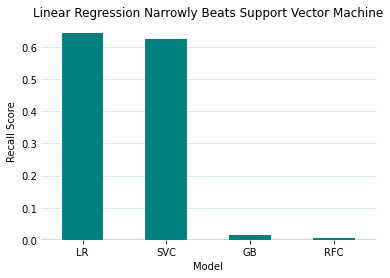

In [21]:
# sort the DataFrame by 'Recall' column
scores_df_sorted = scores_df.sort_values(by='Recall', ascending=False)

# plot a horizontal bar chart
ax = scores_df_sorted.plot(x='Model', y='Recall', kind='bar', legend=False, color='teal')

# Add title and labels for x-axis & y-axis
ax.set_title('Linear Regression Narrowly Beats Support Vector Machine')
ax.set_xlabel('Model')
ax.set_ylabel('Recall Score')

plt.xticks(rotation=0)

# Add horizontal lines behind the bars.
for i in range(0, 7):
    plt.axhline(y=i/10, color='lightblue', zorder=-1, linewidth=0.5)
    
# Add a horizontal line at 0.0
plt.axhline(y=0.0, color='lightblue', zorder=-1, linewidth=1.50)

# Remove the spines of the plot
sns.despine(bottom=True, left=True)

# Remove the little ticks on the y-axis
plt.tick_params(axis='y', which='both', length=0)

# Save the figure as a PNG image with a specified resolution and tight bounding box
plt.savefig('Images/Recall Scores by Model', dpi=300, bbox_inches='tight')

plt.show()

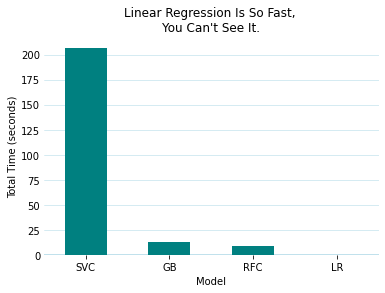

In [22]:
# sort the DataFrame by 'Total Time' column
times_df_sorted = scores_df.sort_values(by='Total Time', ascending=False)

# plot a horizontal bar chart
ax = times_df_sorted.plot(x='Model', y='Total Time', kind='bar', legend=False, color='teal')

# Add title and labels for x-axis & y-axis
ax.set_title("Linear Regression Is So Fast, \nYou Can't See It.")
ax.set_xlabel('Model')
ax.set_ylabel('Total Time (seconds)')

plt.xticks(rotation=0)

# Add horizontal lines behind the bars.
for i in range(0, 201, 25):
    plt.axhline(y=i, color='lightblue', zorder=-1, linewidth=0.5)
    
# Add a horizontal line at 0.0
plt.axhline(y=0.0, color='lightblue', zorder=-1, linewidth=1.50)

# Remove the spines of the plot
sns.despine(bottom=True, left=True)

# Remove the little ticks on the y-axis
plt.tick_params(axis='y', which='both', length=0)

# Save the figure as a PNG image with a specified resolution and tight bounding box
plt.savefig('Images/Total Time by Model', dpi=300, bbox_inches='tight')

plt.show()

**Because we care most about detecting true loan defaults, we will move forward with logistic regression as it has the highest recall score. SVC is a close second but it takes much longer to run the model and is still not performing as well.**

In [23]:
# create oversampled training set using synthetic data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# create oversampled training set
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train_scaled, y_train)

# create undersampled training set
rus = RandomUnderSampler(random_state=42, replacement=True)
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled, y_train)

In [24]:
# Use synthetic oversampling

# Train the model on the training data (scaled data)
lr.fit(X_train_smote, y_train_smote)

# Make predictions on the test data (scaled data)
y_pred = lr.predict(X_test_scaled)

# Calculate the metrics
sm_lr_acc = accuracy_score(y_test, y_pred)
sm_lr_prec = precision_score(y_test, y_pred)
sm_lr_rec = recall_score(y_test, y_pred)
sm_lr_f1 = f1_score(y_test, y_pred)
sm_lr_roc_auc = roc_auc_score(y_test, y_pred)

# Print the metrics
print("Accuracy:", sm_lr_acc)
print("Precision:", sm_lr_prec)
print("Recall:", sm_lr_rec)
print("F1 score:", sm_lr_f1)
print("ROC-AUC score:", sm_lr_roc_auc)

Accuracy: 0.6388126461319508
Precision: 0.2402694610778443
Recall: 0.6546566961250849
F1 score: 0.35152400073006024
ROC-AUC score: 0.6453417355834605


In [25]:
# Use random oversampling

# Train the model on the training data (scaled data)
lr.fit(X_train_ros, y_train_ros)

# Make predictions on the test data (scaled data)
y_pred = lr.predict(X_test_scaled)

# Calculate the metrics
ros_lr_acc = accuracy_score(y_test, y_pred)
ros_lr_prec = precision_score(y_test, y_pred)
ros_lr_rec = recall_score(y_test, y_pred)
ros_lr_f1 = f1_score(y_test, y_pred)
ros_lr_roc_auc = roc_auc_score(y_test, y_pred)

# Print the metrics
print("Accuracy:", ros_lr_acc)
print("Precision:", ros_lr_prec)
print("Recall:", ros_lr_rec)
print("F1 score:", ros_lr_f1)
print("ROC-AUC score:", ros_lr_roc_auc)

Accuracy: 0.6393209311782048
Precision: 0.23821527602722462
Recall: 0.6424201223657376
F1 score: 0.34755424788525197
ROC-AUC score: 0.6405980602266172


In [26]:
# Use random udersampling

# Train the model on the training data (scaled data)
lr.fit(X_train_rus, y_train_rus)

# Make predictions on the test data (scaled data)
y_pred = lr.predict(X_test_scaled)

# Calculate the metrics
rus_lr_acc = accuracy_score(y_test, y_pred)
rus_lr_prec = precision_score(y_test, y_pred)
rus_lr_rec = recall_score(y_test, y_pred)
rus_lr_f1 = f1_score(y_test, y_pred)
rus_lr_roc_auc = roc_auc_score(y_test, y_pred)

# Print the metrics
print("Accuracy:", rus_lr_acc)
print("Precision:", rus_lr_prec)
print("Recall:", rus_lr_rec)
print("F1 score:", rus_lr_f1)
print("ROC-AUC score:", rus_lr_roc_auc)

Accuracy: 0.6411507573447189
Precision: 0.23824052885837782
Recall: 0.636981645139361
F1 score: 0.346780162842339
ROC-AUC score: 0.6394327302914113


In [27]:
# create a dictionary of scores for each model
lr_scores_dict = {
    'Model': ['LR','LR: Smote', 'LR: ROS', 'LR: RUS'],
    'Accuracy': [lr_acc, sm_lr_acc, ros_lr_acc, rus_lr_acc],
    'Precision': [lr_prec, sm_lr_prec, ros_lr_prec, rus_lr_prec],
    'Recall': [lr_rec, sm_lr_rec, ros_lr_rec, rus_lr_rec],
    'F1 Score': [lr_f1, sm_lr_f1, ros_lr_f1, rus_lr_f1],
    'ROC-AUC Score': [lr_roc_auc, sm_lr_roc_auc, ros_lr_roc_auc, rus_lr_roc_auc]
}

# create the DataFrame
lr_scores_df = pd.DataFrame(lr_scores_dict)
lr_scores_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC Score
0,LR,0.639219,0.238551,0.644460,0.348209,0.641379
1,LR: Smote,0.638813,0.240269,0.654657,0.351524,0.645342
2,LR: ROS,0.639321,0.238215,0.642420,0.347554,0.640598
3,LR: RUS,0.641151,0.238241,0.636982,0.346780,0.639433


**I will use SMOTE synthetic oversampling to tune my hyperparameters. It had the highest scores in all metrics except accuracy which I am less concerned with.**

In [36]:
start_time = time.time()

# Create a logistic regression object
lr = LogisticRegression(class_weight='balanced', random_state=42)

# Define the hyperparameters to search over
params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.1, 1, 10],
    'solver': ['saga', 'lbfgs', 'newton-cg', 'liblinear'],
    'max_iter': [100, 500, 1000]
}

# Create a RandomizedSearchCV object
lr_random = RandomizedSearchCV(estimator=lr, param_distributions=params, n_iter=10, cv=5, random_state=42, scoring='recall')

# Train the model on the training data
lr_random.fit(X_train_smote, y_train_smote)

# Get the best hyperparameters
best_params = lr_random.best_params_
print(best_params)

# Train the model with the best hyperparameters on the training data
lr = LogisticRegression(random_state=42, **best_params)
lr.fit(X_train_smote, y_train_smote)

# Make predictions on the test data
y_pred = lr.predict(X_test_scaled)

# Calculate the metrics
tuned_lr_acc = accuracy_score(y_test, y_pred)
tuned_lr_prec = precision_score(y_test, y_pred)
tuned_lr_rec = recall_score(y_test, y_pred)
tuned_lr_f1 = f1_score(y_test, y_pred)
tuned_lr_roc_auc = roc_auc_score(y_test, y_pred)
tuned_lr_conf_matrix = confusion_matrix(y_test, y_pred)

end_time = time.time()
tuned_lr_total_time = end_time - start_time

# Print the metrics
print("Accuracy:", tuned_lr_acc)
print("Precision:", tuned_lr_prec)
print("Recall:", tuned_lr_rec)
print("F1 score:", tuned_lr_f1)
print("ROC-AUC score:", tuned_lr_roc_auc)
print('Total Time:', tuned_lr_total_time)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

{'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 500, 'C': 10}
Accuracy: 0.6386093321134492
Precision: 0.24001996007984033
Recall: 0.6539768864717879
F1 score: 0.3511589706150758
ROC-AUC score: 0.644942065038428
Total Time: 75.92716097831726


In [37]:
# create a dictionary of scores for each model
lr_tuned_scores_dict = {
    'Model': ['LR: Smote', 'LR: Smote - Tuned'],
    'Accuracy': [lr_acc, tuned_lr_acc],
    'Precision': [lr_prec, tuned_lr_prec],
    'Recall': [lr_rec, tuned_lr_rec],
    'F1 Score': [lr_f1, tuned_lr_f1],
    'ROC-AUC Score': [lr_roc_auc, tuned_lr_roc_auc]}

# create the DataFrame
lr_tuned_scores_df = pd.DataFrame(lr_tuned_scores_dict)
lr_tuned_scores_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC Score
0,LR: Smote,0.639219,0.238551,0.644460,0.348209,0.641379
1,LR: Smote - Tuned,0.638609,0.240020,0.653977,0.351159,0.644942


**Plot the feature importance & the coefficient matrix.**

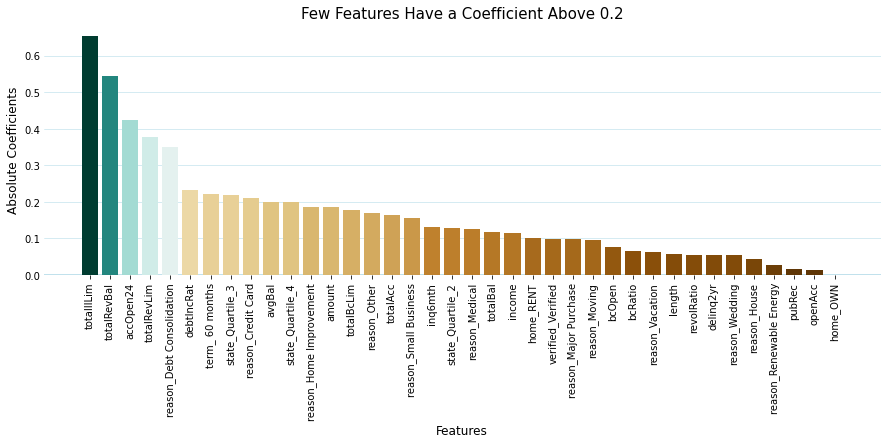

In [40]:
# Create a color gradient for the bar chart
color_map = plt.cm.get_cmap('BrBG')

# Get the absolute coefficients and feature names
coefs = np.abs(lr.coef_[0])
features = list(X_train.columns)

# Sort the coefficients in descending order
sorted_idx = coefs.argsort()[::-1]
sorted_coefs = coefs[sorted_idx]
sorted_features = [features[i] for i in sorted_idx]

# Plot the feature importance with a color gradient
plt.figure(figsize=(15, 6))
bars = plt.bar(sorted_features, sorted_coefs, color=color_map(sorted_coefs / max(sorted_coefs)))
plt.xticks(rotation=90)

# Add title and labels for x-axis & y-axis
plt.xlabel('Features', size=12)
plt.ylabel('Absolute Coefficients', size=12)
plt.title('Few Features Have a Coefficient Above 0.2', size=15)

# Add horizontal lines behind the bars.
for i in range(0, 7):
    plt.axhline(y=i/10, color='lightblue', zorder=-1, linewidth=0.5)
    
# Add a horizontal line at 0.0
plt.axhline(y=0.0, color='lightblue', zorder=-1, linewidth=1.50)

# Remove the spines of the plot
sns.despine(bottom=True, left=True)

# Remove the little ticks on the y-axis
plt.tick_params(axis='y', which='both', length=0)

# Add space between the bars
plt.subplots_adjust(bottom=0.3)

# Save the figure as a PNG image with a specified resolution and tight bounding box
plt.savefig('Images/Feature Importance', dpi=300, bbox_inches='tight')

plt.show()

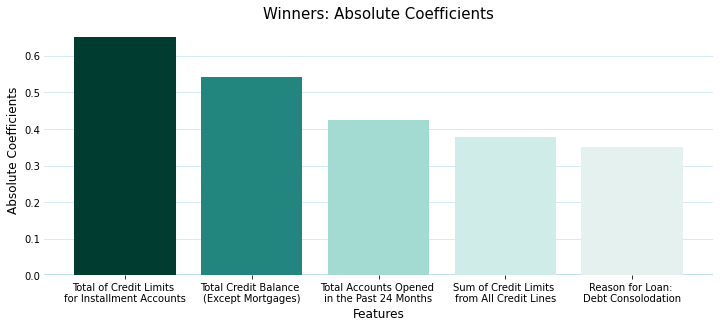

In [41]:
# Create a color gradient for the bar chart
color_map = plt.cm.get_cmap('BrBG')

# Labels for Xticks
x_labels = ['Total of Credit Limits \nfor Installment Accounts', \
                                         'Total Credit Balance \n(Except Mortgages)',\
                                         'Total Accounts Opened \nin the Past 24 Months',\
                                         'Sum of Credit Limits \nfrom All Credit Lines',\
                                         'Reason for Loan: \nDebt Consolodation']

# Get the absolute coefficients and feature names
coefs = np.abs(lr.coef_[0])
features = list(X_train.columns)

# Sort the coefficients in descending order
sorted_idx = coefs.argsort()[::-1]
sorted_coefs = coefs[sorted_idx][:5]
sorted_features = [features[i] for i in sorted_idx][:5]

# Plot the feature importance with a color gradient
plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_features, sorted_coefs, color=color_map(sorted_coefs / max(sorted_coefs)))

# Add title and labels for x-axis, y-axis & x-ticks
plt.title('Winners: Absolute Coefficients', size=15)
plt.xlabel('Features', size=12)
plt.ylabel('Absolute Coefficients', size=12)
plt.xticks(range(len(sorted_features)), labels=x_labels)

# Add horizontal lines behind the bars.
for i in range(1, 7):
    plt.axhline(y=i/10, color='lightblue', zorder=-1, linewidth=0.5)
    
# Add a horizontal line at 0.0
plt.axhline(y=0.0, color='lightblue', zorder=-1, linewidth=1.50)

# Remove the spines of the plot
sns.despine(bottom=True, left=True)

# Remove the little ticks on the y-axis
plt.tick_params(axis='y', which='both', length=0)

# Add space between the bars
plt.subplots_adjust(bottom=0.3)

# Save the figure as a PNG image with a specified resolution and tight bounding box
plt.savefig('Images/Top Coefficients', dpi=300, bbox_inches='tight')

plt.show()

In [32]:
top_features['Absolute Coefficients'] = sorted_features

In [33]:
top_features

,Chi Squared,P-Values,Absolute Coefficients
0,bcOpen,totalRevBal,totalIlLim
1,avgBal,totalBal,totalRevBal
2,totalIlLim,totalRevLim,accOpen24
3,totalRevBal,avgBal,term_ 60 months
4,totalBal,bcOpen,totalRevLim


In [34]:
# Sort the coefficients in descending order
sorted_idx = coefs.argsort()[::-1]
sorted_features = [features[i] for i in sorted_idx]
sorted_coefs = coefs[sorted_idx]

# Create a DataFrame with the sorted features and coefficients
df_feature_importance = pd.DataFrame({'Feature': sorted_features, 'Coefficient': sorted_coefs})

# Print the DataFrame with the feature importance
df_feature_importance

,Feature,Coefficient
0,totalIlLim,0.399352
1,totalRevBal,0.379421
2,accOpen24,0.355878
3,term_ 60 months,0.213849
4,totalRevLim,0.185320
5,debtIncRat,0.171158
6,state_Quartile_4,0.163527
7,totalBcLim,0.153557
8,inq6mth,0.152884
9,amount,0.148732


In [35]:
# Define the base colormap
cmap_base = plt.cm.get_cmap('BrBG')

# Shift the colormap by 30%
shifted_cmap = ListedColormap(cmap_base(np.linspace(0.35, 1, 256)))

# Plot the confusion matrix using the shifted colormap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=shifted_cmap, alpha=0.85)

# Add title and labels for x-axis & y-axis
plt.title('Confusion Matrix', size=15)
plt.xlabel('Predicted Labels', size=12)
plt.ylabel('True Labels', size=12)

# Remove the little ticks on the y-axis
plt.tick_params(which='both', length=0)

# Save the figure as a PNG image with a specified resolution and tight bounding box
plt.savefig('Images/Confusion Matrix', dpi=300, bbox_inches='tight')

plt.show()

NameError: name 'conf_matrix' is not defined

<Figure size 576x432 with 0 Axes>

**I decided to see if I can get slightly better results by engineering new features.**

In [ ]:
stop here

In [ ]:
# New dataframe that includes new engineered features. 
df_eng = df.copy()

In [ ]:
# New feature: Proportion of revolving credit in use.
# "credit utilization rate"  = "totalRevBal" / "totalRevLim"
df_eng["credit_utilization_rate"] = np.round(np.where(df.totalRevLim == 0, 0, df.totalRevBal / df.totalRevLim), 2)

In [ ]:
# New feature: Number of credit lines that are revolving credit.
df_eng['revolving_credit_lines'] = df.totalAcc * df.revolRatio

In [ ]:
# New Feature: Loan amount to income ratio.
df_eng['amount_to_income_ratio'] = round(df.amount / df.income, 2)

In [ ]:
# Confirm new features are not redundant to existing. 
plt.figure(figsize=(20,20))
sns.heatmap(df_eng.corr().round(2), annot=True, cmap='PuOr')
plt.show()

In [ ]:
# Split and then get dummies
X2 = df_eng.drop('status', axis=1)
y2 = df_eng['status']

# Encode y
y2 = y.replace({'Current': 0, 'Default': 1})

# Create dummies and check new feautures
X2 = pd.get_dummies(X2, drop_first=True)

# Change uint8 data tpes to int
uint8_cols = X2.select_dtypes(include='uint8').columns
X2[uint8_cols] = X2[uint8_cols].astype('int')

In [ ]:
# split the data into training and test sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

# initialize a StandardScaler object and fit it on the training data
scaler = StandardScaler()
scaler.fit(X2_train)

# apply the scaling transformation to both the training and test data
X2_train_scaled = scaler.transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)

In [ ]:
# create oversampled training set using synthetic data
smote = SMOTE(random_state=42)
X2_train_smote, y2_train_smote = smote.fit_resample(X2_train_scaled, y2_train)

In [ ]:
# Create a logistic regression object
lr = LogisticRegression(class_weight='balanced', random_state=42, **best_params)

# Train the model on the training data (scaled data)
lr.fit(X2_train_smote, y2_train_smote)

# Make predictions on the test data (scaled data)
y_pred = lr.predict(X2_test_scaled)

# Calculate the metrics
eng_lr_acc = accuracy_score(y_test, y_pred)
eng_lr_prec = precision_score(y_test, y_pred)
eng_lr_rec = recall_score(y_test, y_pred)
eng_lr_f1 = f1_score(y_test, y_pred)
eng_lr_roc_auc = roc_auc_score(y_test, y_pred)

# Print the metrics
print("Accuracy:", eng_lr_acc)
print("Precision:", eng_lr_prec)
print("Recall:", eng_lr_rec)
print("F1 score:", eng_lr_f1)
print("ROC-AUC score:", eng_lr_roc_auc)

In [ ]:
# create a dictionary of scores for each model
lr_eng_scores_dict = {
    'Model': ['LR: Smote', 'LR: Smote - Tuned', 'LR: Smote - Tuned + Eng'],
    'Accuracy': [lr_acc, tuned_lr_acc, eng_lr_acc],
    'Precision': [lr_prec, tuned_lr_prec, eng_lr_prec],
    'Recall': [lr_rec, tuned_lr_rec, eng_lr_rec],
    'F1 Score': [lr_f1, tuned_lr_f1, eng_lr_f1],
    'ROC-AUC Score': [lr_roc_auc, tuned_lr_roc_auc, eng_lr_roc_auc]
}

# create the DataFrame
lr_eng_scores_df = pd.DataFrame(lr_eng_scores_dict)
lr_eng_scores_df

**Looks like the new features have yielded worse results so we'll stop looking at that modified database.**